In [1]:
import numpy as np
import networkx as nx
from numpy.random import default_rng
rng = default_rng(1)
import cvxpy as cp
import random
import math
from sklearn.metrics import matthews_corrcoef, f1_score
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages")
import pysindy as ps
import seaborn as sns
import pandas as pd

In [2]:
# Parameters
N = 100
epsilon = 0.5  
prob = np.round(np.log(N) / N * (1 - epsilon), 5)
T=7
# Generate the graph
G = nx.erdos_renyi_graph(N, prob, seed=1, directed=False)
r_values = [1.2, 2.6, 3, 3.8 ]
np.random.seed(42)
random_numbers = np.round(np.random.rand(N,N),2)
alpha = np.triu(random_numbers) +np.triu(random_numbers).T -np.diag(np.diag(np.triu(random_numbers)))
r_vector = np.sort([r_values[np.random.randint(0,len(r_values))] for p in range(0, N)]) 

In [3]:
def network(G,N, r_vector, T, x0, alpha):
    A = (nx.adjacency_matrix(G).toarray())
    x = np.zeros([T,N])
    x[0,:] = x0
    coupling = np.zeros([T,N])
    
    for k in range(T-1):
        for i in range(N):
            for j in range(N):
                if j != i:
                    coupling[k,i] += A.T[i,j]*alpha[i,j]*(x[k,j]-x[k,i])
                    
            x[k+1,i] = r_vector[i] * x[k,i]+coupling[k,i]     
            
    return x

In [4]:
def signal(N, r_vector, T, alpha):
    signal_matrix = np.zeros([T, N, N])

    # Create different initial conditions for pinching
    initial_conditions = np.zeros((N, N))
    for i in range(N):
        x0 = np.zeros(N)  
        x0[i] = np.random.uniform(0.5, 1) 
        initial_conditions[i, :] = x0 
    
    for i in range(N):
        x0 = initial_conditions[i, :]  
        signal_matrix[:, :, i] = network(G,N, r_vector, T, x0, alpha)
    
    return signal_matrix

In [5]:
def l_1_optimization(y, PHI, solver='ECOS', verbose=False):
    """
    Solve an L1 optimization problem to find the sparsest solution for y = PHI @ x.

    Args:
        y (numpy.ndarray): The target vector of size (n,).
        PHI (numpy.ndarray): The design matrix of size (n, m).
        solver (str): The CVXPY solver to use (default: 'ECOS').
        verbose (bool): If True, prints solver output.

    Returns:
        x_opt (numpy.ndarray): The optimal solution vector of size (m,).
        problem_value (float): The optimal objective value.
    """
    n, m = PHI.shape
    x = cp.Variable(m)
    objective = cp.Minimize(cp.norm(x, 1))
    constraints = [PHI @ x == y]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=solver, verbose=verbose)
    return x.value, problem.value

In [6]:
ww = signal(N, r_vector, T, alpha)

In [7]:
precision = 10**(-9)
meanrate = 60

predictions = np.zeros( [T, N, N])
m_dim = int(N * (meanrate / 100))
M = rng.normal(loc=0, scale=(1 / m_dim), size=(m_dim, N))
for t in range(T):
            for q in range(N):
                Y = np.dot(M, ww[t, :, q]) 
                x_t, nnz_l1 = l_1_optimization(Y, M)
                x_t = np.where(np.abs(x_t) < precision, 0, x_t)
                predictions[ t, :, q] = x_t

In [8]:
mcc_scores = np.zeros([T])
for t in range(1,T):
    sparse_x = ww[:t, :, :].flatten()
    
    supp_of_gt = (sparse_x != 0).astype(int)  # Support of the ground truth 
    supp_of_exp = (predictions[:t].flatten() != 0).astype(int)  # Support of the predicted values
    mcc_scores[t] = matthews_corrcoef(supp_of_gt, supp_of_exp)

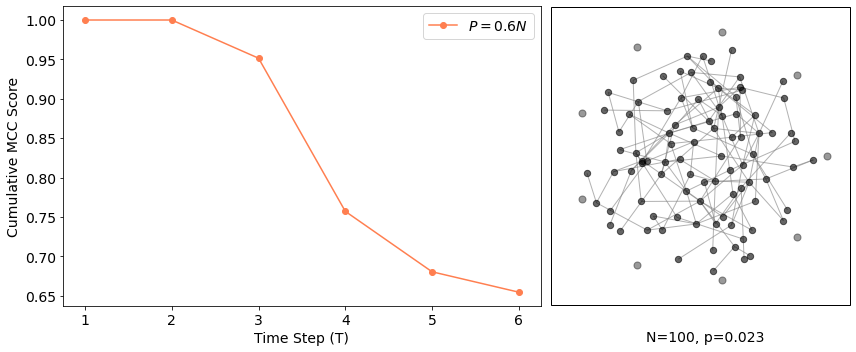

In [9]:
# Parameters
N = 100
epsilon = 0.5
prob = np.round(np.log(N) / N * (1 - epsilon), 5)


G = nx.erdos_renyi_graph(N, prob, seed=1, directed=False)
largest_component = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_component).copy()
excluded_nodes = list(set(G.nodes) - set(G_lcc.nodes))
num_excluded = len(excluded_nodes)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.6, 1]})

ax1 = axs[0]
TT = [1, 2, 3, 4, 5, 6]
ax1.plot(mcc_scores[1:], color='coral', marker='.', markersize=12, label=f'$P=0.6N$')


ax1.set_xlabel('Time Step (T)', fontsize=14)
ax1.set_ylabel('Cumulative MCC Score', fontsize=14)
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(TT, fontsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.grid(False)
ax1.legend(fontsize=14)


ax2 = axs[1]

pos = nx.spring_layout(G_lcc, seed=42, k=0.5, scale=2)
radius = 2.2
angle_step = 2 * np.pi / max(num_excluded, 1)
excluded_pos = {
    node: (radius * np.cos(i * angle_step), radius * np.sin(i * angle_step))
    for i, node in enumerate(excluded_nodes)
}
pos.update(excluded_pos)

nx.draw(G_lcc, pos, ax=ax2, node_size=40, node_color='black', edge_color='gray', alpha=0.6, with_labels=False)
if excluded_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=excluded_nodes, ax=ax2, node_size=50, node_color='black', alpha=0.4)

frame_size = 2.6
frame = Rectangle((-frame_size, -frame_size), 2 * frame_size, 2 * frame_size,
                  linewidth=1, edgecolor='black', facecolor='none',
                  transform=ax2.transData, clip_on=False)
ax2.add_patch(frame)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim(-frame_size, frame_size)
ax2.set_ylim(-frame_size, frame_size)
ax2.set_aspect('equal')
fig.text(0.82, 0.04, f"\nN={N}, p={prob:.3}", fontsize=14, ha='center')
plt.tight_layout()
plt.savefig("cumulative_MCC_scores.pdf", dpi=300, format="pdf")
plt.tight_layout()
plt.show()


In [11]:
coeffs2 = np.zeros([T-1,100,101])
for t in range(0,T-1):
    optimizer = ps.STLSQ(threshold=0.0, alpha = 0.00)
    library = ps.PolynomialLibrary(degree=1,
                                   include_interaction=False)
    model2 = ps.SINDy(optimizer = optimizer,
                     feature_library = library,
                     discrete_time=True)
    model2.fit(predictions[:t+2])
    coeffs2[t] = model2.coefficients()

In [12]:
L=(nx.laplacian_matrix(G).toarray())
Truth = np.diag(r_vector) - alpha * L

In [13]:
for t in range(0,T-1):
    error2 = np.abs(Truth) - np.abs(coeffs2[t,:,1:])
    print("Max absolute error:", np.max(np.abs(error2)))

Max absolute error: 2.0012169357764695
Max absolute error: 1.9599999999935211
Max absolute error: 1.984967459589459
Max absolute error: 2.1055171108186137
Max absolute error: 2.368479227939183
Max absolute error: 6.7102805382327055


In [14]:
for t in range(0, T-1):
    error2 = (Truth) - (coeffs2[t, :, 1:])
    mse2 = np.mean(error2**2)
    
    print(f"Time step T={t+2}")
    print(f"  MSE for coeffs: {mse2:.2e}")

Time step T=2
  MSE for coeffs: 1.10e-02
Time step T=3
  MSE for coeffs: 1.03e-02
Time step T=4
  MSE for coeffs: 1.03e-02
Time step T=5
  MSE for coeffs: 1.09e-02
Time step T=6
  MSE for coeffs: 1.69e-02
Time step T=7
  MSE for coeffs: 5.71e-02


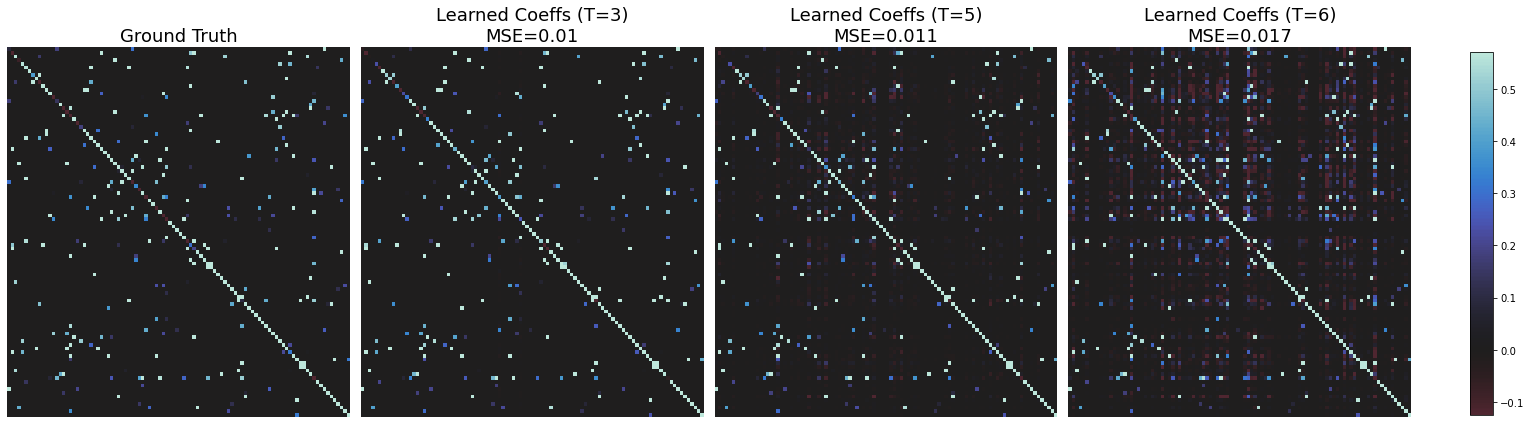

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(22, 6))

all_vals = [Truth] + [coeffs2[t].T[1:, :] for t in [1,3, 4]]
flattened = np.concatenate([mat.flatten() for mat in all_vals])
nonzero_vals = flattened[np.abs(flattened) > 1e-6]  # ignore near-zero


vmin, vmax = np.percentile(nonzero_vals, [2, 96])
cmap = sns.color_palette("icefire_r", as_cmap=True)

# Plot Ground Truth
# Plot Ground Truth
im = sns.heatmap(
    data=Truth,
    cmap=cmap,
    center=0,
    vmin=vmin,
    vmax=vmax,
    ax=axs[0],
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    linecolor='none',
    linewidths=0 ,
    rasterized=True
)
axs[0].set_title("Ground Truth", fontsize=18)

selected_ts = [1, 3, 4]
for i, t in enumerate(selected_ts):
    error2 = Truth - coeffs2[t, :, 1:]
    mse2 = np.mean(error2**2)

    sns.heatmap(
        data=coeffs2[t].T[1:, :],
        cmap=cmap,
        center=0,
        vmin=vmin,
        vmax=vmax,
        ax=axs[i + 1],
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        linewidths=0,
        linecolor='none',
        rasterized=True
    )
    axs[i + 1].set_title(f"Learned Coeffs (T={t+2})\nMSE={mse2:.2}", fontsize=18)


cbar_ax = fig.add_axes([0.93, 0.03, 0.015, 0.84])
fig.colorbar(im.get_children()[0], cax=cbar_ax)
plt.subplots_adjust(wspace=0.4)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("heatmap_ER.pdf", dpi=300, format="pdf")
plt.show()
